Imports.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import os
import numpy as np
import dgym as dg
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Opening experimental results.

In [17]:
path = '../../dgym-data/analysis/batch_size/2024-02-20_22-00-43/'
files = os.listdir(path)

results = []
for file in files:
    if file.endswith('json'):
        result = json.load(open(path + file, 'r'))
        results.append(result[0])

df = pd.DataFrame(results)

Convert to ECDF.

In [19]:
def ecdf(costs):
    n_trials = len(costs)
    
    costs_sorted = np.sort(costs)
    costs_sorted = [0.0, *costs_sorted]
    
    n_success = np.arange(1, n_trials + 1)
    n_success = np.array([0, *n_success])
    n_failure = n_trials - n_success
    probs = n_success / n_trials
    
    return costs_sorted, probs, n_success, n_failure

In [56]:
data = pd.DataFrame()
noises = df['batch_size'].unique()
for noise in noises:
    raw_costs = [int(r['time_elapsed']) for r in df.to_dict('records') if r['batch_size'] == noise]
    cost, prob, n_success, n_failure = ecdf(raw_costs)
    temp = pd.DataFrame({
        'cost': cost,
        'prob': prob,
        'n_success': n_success,
        'n_failure': n_failure,
        'batch_size': noise,
    })
    data = pd.concat([data, temp])

Compute confidence interval.

Plot.

In [25]:
from scipy.stats import beta

def compute_confidence_interval(n_success, n_failure):
    ci = beta.interval(0.95, 1 + n_success, 1 + n_failure)
    return ci

In [58]:
data

,cost,prob,n_success,n_failure,batch_size
0,0.0,0.000000,0,48,384.0
1,3.0,0.020833,1,47,384.0
2,3.0,0.041667,2,46,384.0
3,3.0,0.062500,3,45,384.0
4,3.0,0.083333,4,44,384.0
...,...,...,...,...,...
29,300.0,0.878788,29,4,24.0
30,300.0,0.909091,30,3,24.0
31,300.0,0.939394,31,2,24.0
32,300.0,0.969697,32,1,24.0


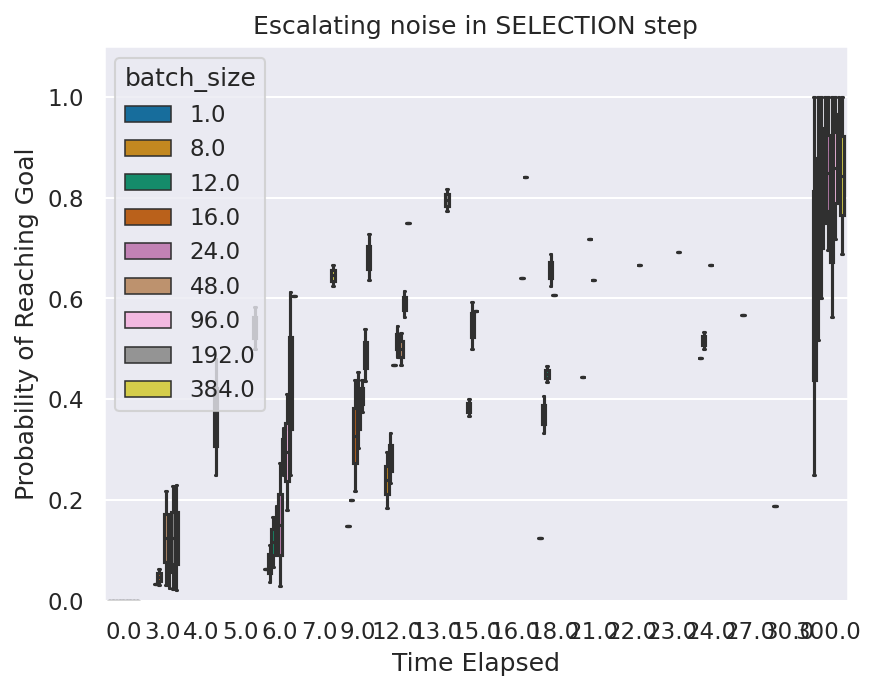

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
g = sns.boxplot(
    data,
    x='cost',
    y='prob',
    hue='batch_size',
    palette='colorblind',
    # errorbar=None
)

# for name, group in data.groupby('batch_size'):

#     lower, upper = compute_confidence_interval(
#         group['n_success'],
#         group['n_failure']
#     )
    
#     g.fill_between(
#         group['cost'],
#         lower,
#         upper,
#         alpha=0.2
#     )

g.set_title('Escalating noise in SELECTION step')
g.set_xlabel('Time Elapsed')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1.1])
# g.set_xlim(0, 1_000)
# plt.legend([], frameon=False)

plt.gcf().set_dpi(150)
plt.show()

Plotting for fixed cost.

In [33]:
at_cost = 200
at_cost_results = []
for sigma, group in df.groupby('batch_size'):
    
    total = len(group)
    n_success = (group['cost'] < at_cost).sum()
    n_failure = total - n_success
    prob = n_success / total
    
    at_cost_results.append(
        {
            'noise': sigma,
            'prob': prob,
            'n_success': n_success,
            'n_failure': n_failure
        }
    )

at_cost_results = pd.DataFrame(at_cost_results)

(0.0, 1.1)

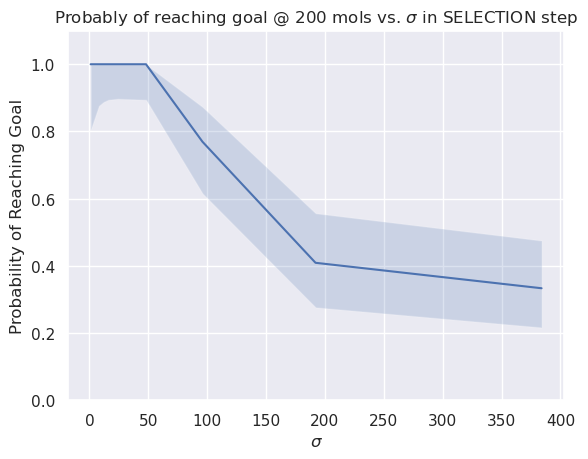

In [34]:
g = sns.lineplot(
    data = at_cost_results,
    x='noise',
    y='prob'
)

lower, upper = compute_confidence_interval(
    at_cost_results['n_success'],
    at_cost_results['n_failure']
)

g.fill_between(
    at_cost_results['noise'],
    lower,
    upper,
    alpha=0.2
)

g.set_title(f'Probably of reaching goal @ {at_cost} mols vs. $\sigma$ in SELECTION step')
g.set_xlabel(f'$\sigma$')
g.set_ylabel(f'Probability of Reaching Goal')
g.set_ylim([0, 1.1])

Plotting expected costs.

Text(0.5, 0, '$\\sigma$')

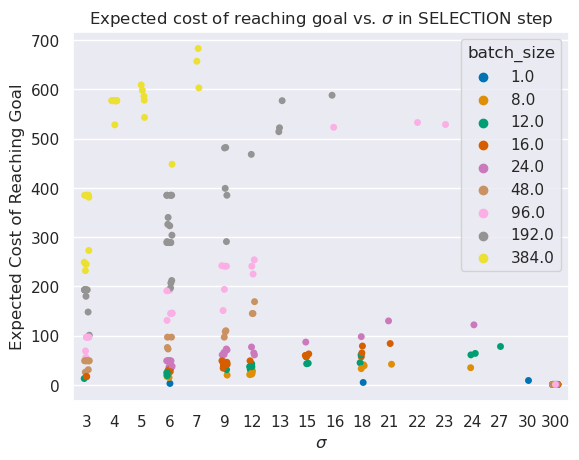

In [44]:
g = sns.stripplot(
    data = df,
    x='time_elapsed',
    y='cost',
    hue='batch_size',
    palette='colorblind'
    # errorbar='sd'
)

g.set_title(f'Expected cost of reaching goal vs. $\sigma$ in SELECTION step')
g.set_ylabel(f'Expected Cost of Reaching Goal')
g.set_xlabel(f'$\sigma$')